In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
from nlinec import get_positive_data, get_all_types, get_results_dir, get_type, color_palette
from nlinec.data.preprocessing import get_granularity

In [69]:
# Import lognorm
from matplotlib.colors import LogNorm

dark_viridis = plt.get_cmap('viridis')(0)
dark_viridis = (dark_viridis[0] * 0.8, dark_viridis[1] * 0.8, dark_viridis[2] * 0.8, 1)

## Setup

In [3]:
# Specify the dataset to predict and a file to save the predictions to
DATASET = 'g_test.json'
SAVE_PREDICTIONS_TO = os.path.join(get_results_dir(), "predictions", "zero-shot", "test_predictions_ho.csv")

# Specify the parameters for the analysis
MODEL = "roberta-large-mnli"

## Setup 

In [4]:
positive_data = get_positive_data(DATASET)
positive_data

Loading g_test.json: 8963it [00:00, 85529.88it/s]


,mention_span,full_type,sentence,label
0,Valley Federal Savings & Loan Association,"[/organization, /organization/company]",Valley Federal Savings & Loan Association sai...,2
1,Valley Federal,"[/organization, /organization/company]","Terms weren't disclosed, but Valley Federal ha...",2
2,Valley Federal,"[/organization, /organization/company]",Valley Federal said Friday that it is conside...,2
3,"Valley Federal , with assets of $ 3.3 billion ,","[/organization, /organization/company]","Valley Federal , with assets of $ 3.3 billion...",2
4,Imperial Corp. of America,"[/organization, /organization/company]",Valley Federal Savings & Loan Association said...,2
...,...,...,...,...
8958,"Fridays in general , which tend to be strong d...",[/other],Another study found that the 82 Fridays the 13...,2
8959,stocks,[/other],"But the date tends to be a plus, not a minus, ...",2
8960,the 1962 - 85 period,[/other],"But their study, which spanned the 1962 - 85 p...",2
8961,professors,[/person],"Robert Kolb and Ricardo Rodriguez, professors ...",2


In [5]:
gran_types = []
for i in [1, 2, 3]:
    all_types = get_all_types(granularity=i)
    all_types['granularity'] = all_types['full_type'].apply(lambda x: get_granularity(x))
    gran_types.append(all_types[all_types['granularity'] == i])

## Evaluate

In [6]:
# Get the predictions
predictions_df = pd.read_csv(SAVE_PREDICTIONS_TO, index_col=0)

# Combine the predictions with the original data based on the index
data_with_predictions = positive_data.join(predictions_df).explode('full_type')

# Add the granularity of the type
data_with_predictions['granularity'] = data_with_predictions['full_type'].apply(get_granularity)

# Reset the index
data_with_predictions.reset_index(drop=True, inplace=True)

In [18]:
# data_with_predictions.drop_duplicates(subset=['full_type', 'mention_span'])

In [8]:
# Compute the predicted type for each granularity
for i in [1, 2, 3]:
    # Get the rows where the correct type has the correct granularity
    granularity_mask = data_with_predictions['granularity'] == i

    # Add a new column which stores the predicted type (i.e. the the name of the column with the maximum probability)
    data_with_predictions.loc[granularity_mask, 'predicted_type'] = data_with_predictions.loc[granularity_mask, list(gran_types[i - 1]['full_type'])].idxmax(axis=1)
    
    # Add a column that stores if the prediction was correct
    data_with_predictions.loc[granularity_mask, 'correct'] = data_with_predictions.loc[granularity_mask, 'predicted_type'] == data_with_predictions.loc[granularity_mask, 'full_type']

In [60]:
# Find the entities that are most often misclassified at each granularity
entities_evaluation_at_granularity = []
for i in [1, 2, 3]:
    # Get the rows where the correct type has the correct granularity
    granularity_mask = data_with_predictions['granularity'] == i

    # Define a dataframe that stores the number of occurences of each entity, to which later the number of wrong and correct predictions for the entity will be added
    entities_evaluation = pd.DataFrame(data_with_predictions.loc[granularity_mask, 'mention_span'].value_counts().rename_axis('mention_span').reset_index(name='nec_count'))

    # Get the rows where the correct type has the correct granularity and the prediction is wrong or correct
    entities_correct = data_with_predictions.loc[granularity_mask & data_with_predictions['correct']]
    entities_misclassified = data_with_predictions.loc[granularity_mask & ~(data_with_predictions['correct'].astype(bool))]

    # Count the number of occucrrences of each entity in the misclassified list
    entities_misclassified = entities_misclassified['mention_span'].value_counts().rename_axis('mention_span').reset_index(name='wrong_count')
    entities_correct = entities_correct['mention_span'].value_counts().rename_axis('mention_span').reset_index(name='correct_count')

    # Merge the two dataframes
    entities_evaluation = entities_evaluation.merge(entities_misclassified, on='mention_span', how='left')
    entities_evaluation = entities_evaluation.merge(entities_correct, on='mention_span', how='left')

    # Fill the NaN values with 0
    entities_evaluation.fillna(0, inplace=True)
    
    # Append the dataframe to the list
    entities_evaluation_at_granularity.append(entities_evaluation)

In [36]:
from datasets import load_dataset

dataset = load_dataset("multi_nli")
dataset['train']

/home/psaegert/miniconda3/envs/fsem/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset multi_nli (/home/psaegert/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39)
100%|██████████| 3/3 [00:00<00:00,  8.94it/s]


Dataset({
    features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
    num_rows: 392702
})

In [38]:
# Combine the premise and hypothesis into one column
mnli_df = pd.DataFrame(dataset['train'])
mnli_df['text'] = mnli_df['premise'] + ' ' + mnli_df['hypothesis']
mnli_df.drop(columns=['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'], inplace=True)

In [47]:
# Count how often each entity occurs in the MNLI dataset
mnli_entity_counts = pd.DataFrame(data_with_predictions['mention_span'].unique(), columns=['mention_span'])

for i in tqdm(range(0, len(entities_evaluation), 100)):
    mnli_entity_counts.loc[i:i + 100, 'mnli_count'] = mnli_entity_counts.loc[i:i + 100, 'mention_span'].apply(lambda x: mnli_df['text'].str.contains(x).sum())

mnli_entity_counts

100%|██████████| 73/73 [13:27<00:00, 11.06s/it]


,mention_span,mnli_count
0,Valley Federal Savings & Loan Association,0.0
1,Valley Federal,0.0
2,"Valley Federal , with assets of $ 3.3 billion ,",0.0
3,Imperial Corp. of America,0.0
4,"Imperial Corp. , whose spokesman said the comp...",0.0
...,...,...
7281,Robert Kolb and Ricardo Rodriguez,0.0
7282,"Fridays in general , which tend to be strong d...",0.0
7283,the 1962 - 85 period,0.0
7284,professors,110.0


In [61]:
# Add the counts to the entities_evaluation dataframes
for i in [1, 2, 3]:
    entities_evaluation_at_granularity[i - 1] = entities_evaluation_at_granularity[i - 1].merge(mnli_entity_counts, on='mention_span', how='left')

    # Fill the NaN values with 0
    entities_evaluation_at_granularity[i - 1].fillna(0, inplace=True)

    # Compute the accuracy
    entities_evaluation_at_granularity[i - 1]['accuracy'] = entities_evaluation_at_granularity[i - 1]['correct_count'] / entities_evaluation_at_granularity[i - 1]['nec_count']

In [62]:
entities_evaluation_at_granularity[0]

,mention_span,nec_count,wrong_count,correct_count,mnli_count,accuracy
0,China,41,41.0,0.0,917.0,0.0
1,China 's,29,29.0,0.0,0.0,0.0
2,last year,26,26.0,0.0,945.0,0.0
3,Xinhua News Agency,24,0.0,24.0,0.0,1.0
4,-LRB- End -RRB-,20,20.0,0.0,0.0,0.0
...,...,...,...,...,...,...
7281,$ 2 billion,1,1.0,0.0,0.0,0.0
7282,"Hill Financial Savings Association , Red Hill ...",1,0.0,1.0,0.0,1.0
7283,Pacific Savings Bank,1,1.0,0.0,0.0,0.0
7284,$ 3.5 billion,1,1.0,0.0,0.0,0.0


In [122]:
max_wrong_or_right_count = int(max(entities_evaluation_at_granularity[0]['wrong_count'].max(), entities_evaluation_at_granularity[0]['correct_count'].max()))
max_wrong_or_right_count

41

In [131]:
cmax = 0
for i in [1, 2, 3]:
    entities_evaluation = entities_evaluation_at_granularity[i - 1]
    hist, xedges, yedges = np.histogram2d(entities_evaluation['wrong_count'], entities_evaluation['mnli_count'], bins=(max_wrong_or_right_count // 3, max_wrong_or_right_count // 3))
    cmax = max(cmax, hist.max())
cmax

7125.0

In [ ]:
def number_to_reduced_string(n):
    if n < 1e3:
        return str(n)
    elif n < 1000000:
        return str(int(n // 1e3)) + 'k'
    else:
        return str(int(n // 1e6)) + 'M'

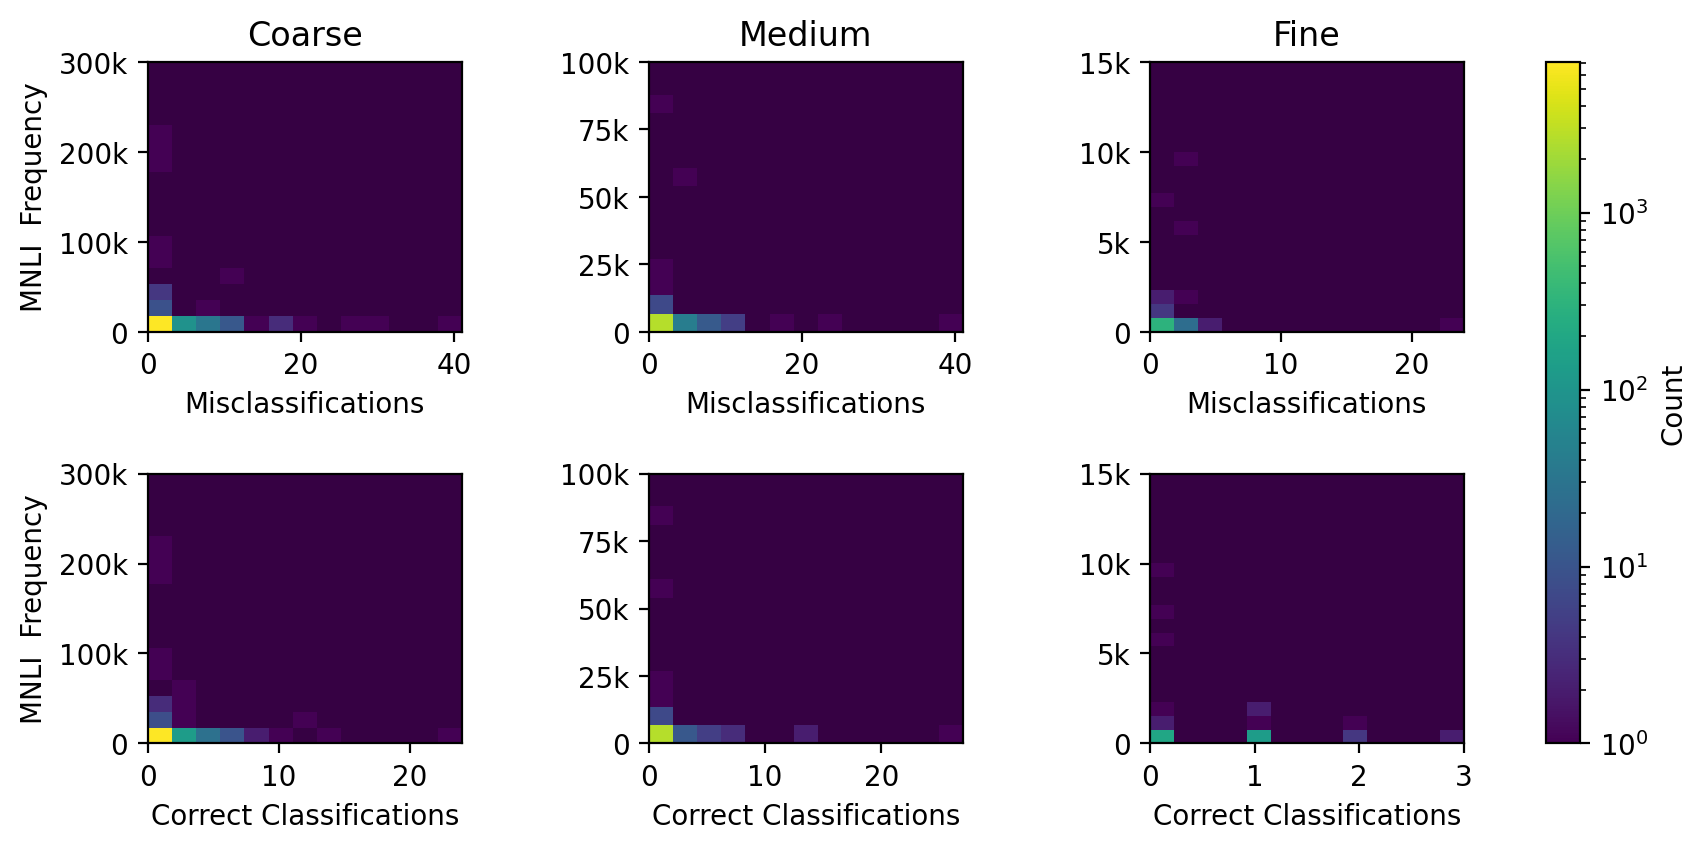

In [146]:
fig, axes = plt.subplots(2, 3, figsize=(9, 4), dpi=200)
fig.tight_layout(w_pad=5, h_pad=3)
for r, (ax_row, result) in enumerate(zip(axes, ['wrong_count', 'correct_count'])):
    for i, ax, granularity in zip([1, 2, 3], ax_row, ['Coarse', 'Medium', 'Fine']):
        # Get the entity evaluation dataframe for the current granularity
        entities_evaluation = entities_evaluation_at_granularity[i - 1]

        # Draw a 2d histogram of the entity frequency per misclassification count
        ax.hist2d(entities_evaluation[result], entities_evaluation['mnli_count'], bins=[max_wrong_or_right_count // 3, max_wrong_or_right_count // 3], norm=LogNorm(vmin=1, vmax=cmax))
        if r == 0:
            ax.set_title(f'{granularity}')

        if r == 0:
            ax.set_xlabel('Misclassifications')
        else:
            ax.set_xlabel('Correct Classifications')
        ax.set_facecolor(dark_viridis)
        ax.set_yticks(ax.get_yticks())
        ax.set_yticklabels([number_to_reduced_string(y) for y in ax.get_yticks()])


axes[0, 0].set_ylabel('MNLI  Frequency');
axes[1, 0].set_ylabel('MNLI  Frequency');

fig.colorbar(axes[0, 0].collections[0], ax=axes, location='right', label='Count');

In [147]:
cmax = 0
for i in [1, 2, 3]:
    entities_evaluation = entities_evaluation_at_granularity[i - 1]
    hist, xedges, yedges = np.histogram2d(entities_evaluation['accuracy'], entities_evaluation['mnli_count'], bins=(max_wrong_or_right_count // 3, max_wrong_or_right_count // 3))
    cmax = max(cmax, hist.max())
cmax

5577.0

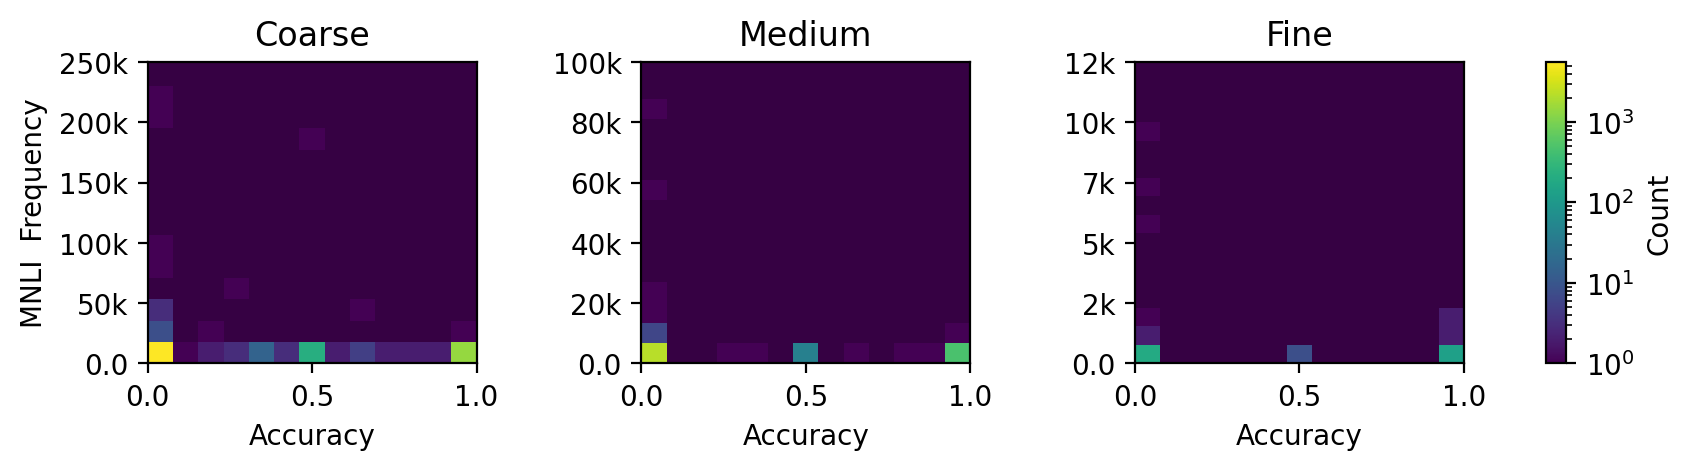

In [172]:
fig, axes = plt.subplots(1, 3, figsize=(9, 2.1), dpi=200)
fig.tight_layout(w_pad=4)
for i, ax, granularity in zip([1, 2, 3], axes, ['Coarse', 'Medium', 'Fine']):
    # Get the entity evaluation dataframe for the current granularity
    entities_evaluation = entities_evaluation_at_granularity[i - 1]

    # Draw a 2d histogram of the entity frequency per misclassification count
    ax.hist2d(entities_evaluation['accuracy'], entities_evaluation['mnli_count'], bins=[max_wrong_or_right_count // 3, max_wrong_or_right_count // 3], norm=LogNorm(vmin=1, vmax=cmax))
    ax.set_title(f'{granularity}')

    ax.set_xlabel('Accuracy')
    ax.set_facecolor(dark_viridis)
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels([number_to_reduced_string(y) for y in ax.get_yticks()])


axes[0].set_ylabel('MNLI  Frequency');

fig.colorbar(axes[0].collections[0], ax=axes, location='right', label='Count', aspect=15);